In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [2]:
!pip install -q kaggle
print("Please upload your kaggle.json key")
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json key


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%%capture
! kaggle datasets download 'sigfest/database-for-emotion-recognition-system-gameemo'
! unzip database-for-emotion-recognition-system-gameemo.zip

# /content/database-for-emotion-recognition-system-gameemo.zip
path = '/content/GAMEEMO'

In [ ]:
!pip install mne
!pip install pymatreader
import mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.9 MB/s eta 0:00:00


In [ ]:
#FOR EX: If we want to access only the first 10 time points of channel 8 we would use:
"""
print(raw._data[8, :11])
print(type(raw._data))
print(raw._data.shape)
"""

'\nprint(raw._data[8, :11])\nprint(type(raw._data))\nprint(raw._data.shape)\n'

In [ ]:
def get_patient(pn):
  X = [] # data
  y = [] # labels
  for g in range(1, 5):
    g = str(g)
    test_csv = os.path.join(path, f'(S{pn})/Preprocessed EEG Data/.csv format/S{pn}G{g}AllChannels.csv')
    df = pd.read_csv(test_csv)
    df = df.drop(columns=['Unnamed: 14'])
    col_names = list(df.columns)
    mne_info = mne.create_info(col_names, sfreq=128, ch_types='eeg') # sr should mean 5min result
    raw = mne.io.RawArray(df.transpose(), mne_info)
    raw.set_montage('standard_1005')
    #raw.compute_psd().plot()
    X.append(raw._data)
    y.append(g)
  return X, y

get_patient(11)

Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=38252
    Range : 0 ... 38251 =      0.000 ...   298.836 secs
Ready.


([array([[  9.1588,   7.6454,   1.1609, ...,   4.9624,  -3.7712, -12.9451],
         [ -4.8205,  -6.9414,  -9.6586, ...,   1.1039,  -4.0238,  -4.5053],
         [ 20.7284,  11.7719,  15.6447, ...,  -4.6647,  -3.6617,  -9.4676],
         ...,
         [  4.3385,   4.5602,   7.4198, ...,   1.3582,   8.7485,   4.1262],
         [ -4.3385,  -4.5602,  -1.6352, ...,  -5.0825,  -1.1622,   3.9691],
         [ 10.6051,  14.3075,   5.4951, ...,   2.2563,   2.8441,  -2.3881]]),
  array([[-23.6207 , -14.0083 , -19.4348 , ...,   8.0576 ,   1.7898 ,
           -7.9588 ],
         [-21.6925 , -17.9804 , -16.902  , ...,   8.7568 ,  13.5338 ,
            5.9731 ],
         [-20.7282 , -24.7871 , -29.5664 , ..., -10.7091 ,  -3.3178 ,
           -4.5648 ],
         ...,
         [-38.5643 , -34.3223 , -34.6731 , ..., -13.1527 ,  -4.6505 ,
           -1.4796 ],
         [ 37.6    ,  26.6669 ,  20.2466 , ...,  -2.4561 ,   9.7426 ,
            0.48074],
         [ 24.1026 ,  26.5129 ,  21.0657 , ...,  -1.20

In [ ]:
def get_all_patients():
  X = []
  y = []
  subject_ids = []
  for pn in tqdm(range(1, 29)):
    pn = str(pn).zfill(2)
    for g in range(1, 5):
      test_csv = os.path.join(path, f'(S{pn})/Preprocessed EEG Data/.csv format/S{pn}G{g}AllChannels.csv')
      df = pd.read_csv(test_csv)
      df = df.drop(columns=['Unnamed: 14'])
      col_names = list(df.columns)
      mne_info = mne.create_info(col_names, sfreq=128, ch_types='eeg') # sr should mean 5min result
      raw = mne.io.RawArray(df.transpose(), mne_info, verbose='CRITICAL')
      raw.set_montage('standard_1005')
      X.append(raw._data)
      y.append(g)
      subject_ids.append(pn)
  #return X, y, subject_ids
  return np.array(X), np.array(y), np.array(subject_ids)

In [ ]:
datas, labels, subjects = get_all_patients()
datas.shape

100%|██████████| 28/28 [00:15<00:00,  1.76it/s]


(112, 14, 38252)

In [ ]:
len(datas), datas[0].shape

(112, (14, 38252))

In [ ]:
# CLAUDE 3.7 Sonnet
def extract_features(X):
    """
    Extract features from EEG data.

    Parameters:
    X (np.array): Raw EEG data with shape (n_samples, n_channels, n_timepoints)

    Returns:
    features (np.array): Extracted features with shape (n_samples, n_features)
    """
    n_samples = X.shape[0]
    features = []

    for i in range(n_samples):
        sample_features = []

        # For each channel, extract:
        # 1. Mean
        # 2. Standard deviation
        # 3. Min, Max
        # 4. Frequency domain features (if needed)

        # Mean and std for each channel
        channel_means = np.mean(X[i], axis=1)
        channel_stds = np.std(X[i], axis=1)

        # Min and max for each channel
        channel_mins = np.min(X[i], axis=1)
        channel_maxs = np.max(X[i], axis=1)

        # Combine features
        sample_features = np.concatenate([
            channel_means,
            channel_stds,
            channel_mins,
            channel_maxs
        ])

        features.append(sample_features)

    return np.array(features)

features = extract_features(datas)
features.shape, features

((112, 56),
 array([[ 1.36107224e-02,  6.08219408e-03,  4.38608942e-03, ...,
          5.56290000e+01,  1.14101300e+02,  5.63144000e+01],
        [ 1.03475354e-02,  3.08122091e-03,  2.40548920e-02, ...,
          5.41328000e+01,  2.26865200e+02,  4.20870000e+01],
        [ 1.22379994e-02,  2.76708327e-03,  1.92538069e-02, ...,
          8.31734000e+01,  9.45867000e+01,  4.31276000e+01],
        ...,
        [ 6.15980926e-04,  4.17026657e-03,  7.05672915e-03, ...,
          1.40896600e+02,  9.63592000e+01,  7.31873000e+01],
        [ 2.28642922e-03,  7.66382371e-03, -2.74298811e-03, ...,
          8.89611000e+01,  6.81332000e+01,  1.24924500e+02],
        [ 1.12802521e-02,  3.56101225e-02, -1.34141074e-02, ...,
          6.52470000e+01,  4.72132000e+01,  5.26304000e+01]]))

In [ ]:
# CLAUDE 3.7 Sonnet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def train_evaluate_model(X, y, subject_ids, test_size=0.2, random_state=42):
    """
    Train and evaluate a classification model on the EEG data.
    Uses subject-wise splitting to ensure no data leakage.

    Parameters:
    X (np.array): Feature array
    y (np.array): Labels array
    subject_ids (np.array): Subject IDs array
    test_size (float): Proportion of data to use for testing
    random_state (int): Random seed for reproducibility

    Returns:
    model (Pipeline): Trained classification model
    test_accuracy (float): Accuracy on the test set
    """
    # Get unique subject IDs
    unique_subjects = np.unique(subject_ids)

    # Split subjects into train and test groups
    train_subjects, test_subjects = train_test_split(
        unique_subjects, test_size=test_size, random_state=random_state
    )

    # Create train and test masks based on subject IDs
    train_mask = np.isin(subject_ids, train_subjects)
    test_mask = np.isin(subject_ids, test_subjects)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Create and train the model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000))
    ])

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    print(f"Train accuracy: {train_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")

    # Detailed evaluation
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return model, test_accuracy

Loading EEG dataset...


100%|██████████| 28/28 [00:15<00:00,  1.78it/s]


Dataset loaded: 112 samples, 4 classes
Samples per class: [28, 28, 28, 28]
Number of subjects: 28
Extracting features...
Features extracted: 56 features per sample
Training and evaluating model...
Train accuracy: 1.000
Test accuracy: 0.708

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         6
           2       0.83      0.83      0.83         6
           3       0.71      0.83      0.77         6
           4       0.60      0.50      0.55         6

    accuracy                           0.71        24
   macro avg       0.70      0.71      0.70        24
weighted avg       0.70      0.71      0.70        24



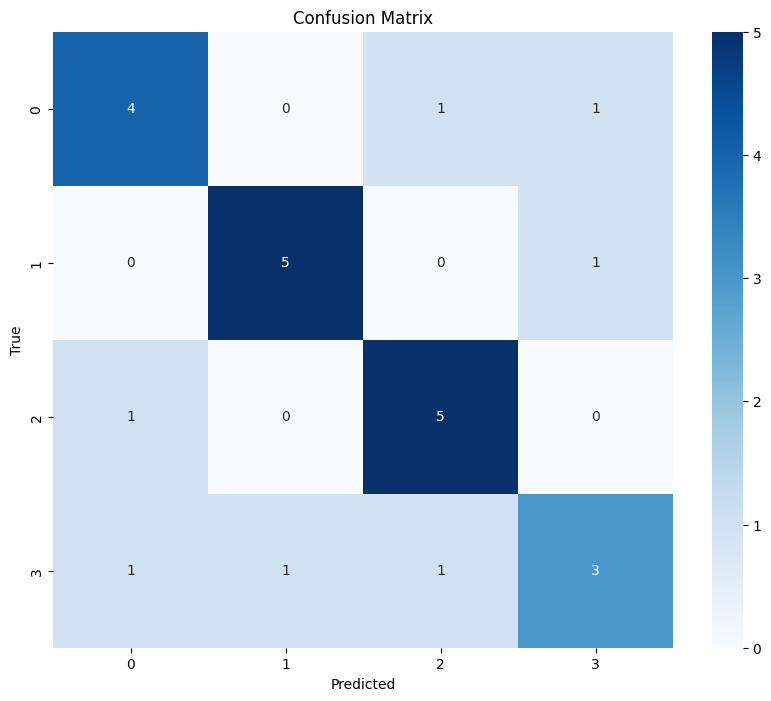

Final model accuracy: 0.708


SyntaxError: 'return' outside function (<ipython-input-31-3bd4f6adf049>, line 19)

In [ ]:
# CLAUDE 3.7 Sonnet
print("Loading EEG dataset...")
X_raw, y, subject_ids = get_all_patients() #load_eeg_dataset(base_dir)

print(f"Dataset loaded: {X_raw.shape[0]} samples, {len(np.unique(y))} classes")
print(f"Samples per class: {pd.Series(y).value_counts().sort_index().tolist()}")
print(f"Number of subjects: {len(np.unique(subject_ids))}")

# Extract features
print("Extracting features...")
X_features = extract_features(X_raw)
print(f"Features extracted: {X_features.shape[1]} features per sample")

# Train and evaluate
print("Training and evaluating model...")
model, accuracy = train_evaluate_model(X_features, y, subject_ids)

print(f"Final model accuracy: {accuracy:.3f}")
return model